## Get data

In [4]:
# %load ../src/data/get_data.py
import subprocess
import os

import pandas as pd
import numpy as np

from datetime import datetime

import requests
import json

def get_johns_hopkins():
    ''' Get data by a git pull request, the source code has to be pulled first
        Result is stored in the predifined csv structure
    '''
    git_pull = subprocess.Popen( "git pull" ,
                         cwd = os.path.dirname( '../data/raw/COVID-19/' ),
                         shell = True,
                         stdout = subprocess.PIPE,
                         stderr = subprocess.PIPE )
    (out, error) = git_pull.communicate()


    print("Error : " + str(error))
    print("out : " + str(out))


if __name__ == '__main__':
    get_johns_hopkins()

Error : b''
out : b'Already up to date.\n'


## Process data

In [1]:
# %load ../src/data/process_JH_data.py
import pandas as pd
import numpy as np

from datetime import datetime


def store_relational_JH_data():
    ''' Transformes the COVID data in a relational data set
    '''

    data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    pd_raw=pd.read_csv(data_path)

    pd_data_base=pd_raw.rename(columns={'Country/Region':'country',
                      'Province/State':'state'})

    pd_data_base['state']=pd_data_base['state'].fillna('no')

    pd_data_base=pd_data_base.drop(['Lat','Long'],axis=1)


    pd_relational_model=pd_data_base.set_index(['state','country']) \
                                .T                              \
                                .stack(level=[0,1])             \
                                .reset_index()                  \
                                .rename(columns={'level_0':'date',
                                                   0:'confirmed'},
                                                  )

    pd_relational_model['date']=pd_relational_model.date.astype('datetime64[ns]')

    pd_relational_model.to_csv('../data/processed/COVID_relational_confirmed.csv',sep=';',index=False)
    print(' Number of rows stored: '+str(pd_relational_model.shape[0]))

if __name__ == '__main__':

    store_relational_JH_data()

 Number of rows stored: 260490


## Filter and doubling Rate Calculation

In [3]:
# %load ../src/features/build_features1.py
import numpy as np
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)
import pandas as pd

from scipy import signal


def get_doubling_time_via_regression(in_array):
    ''' Use a linear regression to approximate the doubling rate
        Parameters:
        ----------
        in_array : pandas.series
        Returns:
        ----------
        Doubling rate: double
    '''

    y = np.array(in_array)
    X = np.arange(-1,2).reshape(-1, 1)

    assert len(in_array)==3
    reg.fit(X,y)
    intercept=reg.intercept_
    slope=reg.coef_

    return intercept/slope


def savgol_filter(df_input,column='confirmed',window=11):
    ''' Savgol Filter which can be used in groupby apply function (data structure kept)
        parameters:
        ----------
        df_input : pandas.series
        column : str
        window : int
            used data points to calculate the filter result
        Returns:
        ----------
        df_result: pd.DataFrame
            the index of the df_input has to be preserved in result
    '''

    degree=1
    df_result=df_input

    filter_in=df_input[column].fillna(0) # attention with the neutral element here

    result=signal.savgol_filter(np.array(filter_in),
                           window, # window size used for filtering
                           1)
    df_result[str(column+'_filtered')]=result
    return df_result

def rolling_reg(df_input,col='confirmed'):
    ''' Rolling Regression to approximate the doubling time'
        Parameters:
        ----------
        df_input: pd.DataFrame
        col: str
            defines the used column
        Returns:
        ----------
        result: pd.DataFrame
    '''
    days_back=3
    result=df_input[col].rolling(
                window=days_back,
                min_periods=days_back).apply(get_doubling_time_via_regression,raw=False)



    return result




def calc_filtered_data(df_input,filter_on='confirmed'):
    '''  Calculate savgol filter and return merged data frame
        Parameters:
        ----------
        df_input: pd.DataFrame
        filter_on: str
            defines the used column
        Returns:
        ----------
        df_output: pd.DataFrame
            the result will be joined as a new column on the input data frame
    '''

    must_contain=set(['state','country',filter_on])
    assert must_contain.issubset(set(df_input.columns)), ' Erro in calc_filtered_data not all columns in data frame'

    df_output=df_input.copy() # we need a copy here otherwise the filter_on column will be overwritten

    pd_filtered_result=df_output[['state','country',filter_on]].groupby(['state','country']).apply(savgol_filter)#.reset_index()

    #print('--+++ after group by apply')
    #print(pd_filtered_result[pd_filtered_result['country']=='Germany'].tail())

    #df_output=pd.merge(df_output,pd_filtered_result[['index',str(filter_on+'_filtered')]],on=['index'],how='left')
    df_output=pd.merge(df_output,pd_filtered_result[[str(filter_on+'_filtered')]],left_index=True,right_index=True,how='left')
    #print(df_output[df_output['country']=='Germany'].tail())
    return df_output.copy()





def calc_doubling_rate(df_input,filter_on='confirmed'):
    ''' Calculate approximated doubling rate and return merged data frame
        Parameters:
        ----------
        df_input: pd.DataFrame
        filter_on: str
            defines the used column
        Returns:
        ----------
        df_output: pd.DataFrame
            the result will be joined as a new column on the input data frame
    '''

    must_contain=set(['state','country',filter_on])
    assert must_contain.issubset(set(df_input.columns)), ' Erro in calc_filtered_data not all columns in data frame'


    pd_DR_result= df_input.groupby(['state','country']).apply(rolling_reg,filter_on).reset_index()

    pd_DR_result=pd_DR_result.rename(columns={filter_on:filter_on+'_DR',
                             'level_2':'index'})

    #we do the merge on the index of our big table and on the index column after groupby
    df_output=pd.merge(df_input,pd_DR_result[['index',str(filter_on+'_DR')]],left_index=True,right_on=['index'],how='left')
    df_output=df_output.drop(columns=['index'])


    return df_output


if __name__ == '__main__':
    test_data_reg=np.array([2,4,6])
    result=get_doubling_time_via_regression(test_data_reg)
    print('the test slope is: '+str(result))

    pd_JH_data=pd.read_csv('../data/processed/COVID_relational_confirmed.csv',sep=';',parse_dates=[0])
    pd_JH_data=pd_JH_data.sort_values('date',ascending=True).copy()

    #test_structure=pd_JH_data[((pd_JH_data['country']=='US')|
    #                  (pd_JH_data['country']=='Germany'))]

    pd_result_larg=calc_filtered_data(pd_JH_data)
    pd_result_larg=calc_doubling_rate(pd_result_larg)
    pd_result_larg=calc_doubling_rate(pd_result_larg,'confirmed_filtered')


    mask=pd_result_larg['confirmed']>100
    pd_result_larg['confirmed_filtered_DR']=pd_result_larg['confirmed_filtered_DR'].where(mask, other=np.NaN)
    pd_result_larg.to_csv('../data/processed/COVID_final_set.csv',sep=';',index=False)
    print(pd_result_larg[pd_result_larg['country']=='Germany'].tail())

the test slope is: [2.]
             date state  country   confirmed  confirmed_filtered  \
140751 2022-07-19    no  Germany  29994679.0        3.000107e+07   
140752 2022-07-20    no  Germany  30131303.0        3.009394e+07   
140753 2022-07-21    no  Germany  30239122.0        3.018682e+07   
140754 2022-07-22    no  Germany  30331131.0        3.027969e+07   
140755 2022-07-23    no  Germany  30331133.0        3.037256e+07   

        confirmed_DR  confirmed_filtered_DR  
140751    197.866127             321.809842  
140752    216.071584             323.037766  
140753    246.451740             324.037766  
140754    302.598755             325.037766  
140755    658.626947             326.037766  


## Visualization

In [7]:
# %load ../src/visualization/visualize1.py
import pandas as pd
import numpy as np

import dash
dash.__version__
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "browser"

import os
print(os.getcwd())
df_input_large=pd.read_csv('../data/processed/COVID_final_set.csv',sep=';')


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Applied Data Science on COVID-19 data
    Goal of the project is to teach data science by applying a cross industry standard process,
    it covers the full walkthrough of: automated data gathering, data transformations,
    filtering and machine learning to approximating the doubling time, and
    (static) deployment of responsive dashboard.
    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),


    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_input_large['country'].unique()],
        value=['Australia', 'Germany','Italy'], # which are pre-selected
        multi=True
    ),

    dcc.Markdown('''
        ## Select Timeline of confirmed COVID-19 cases or the approximated doubling time
        '''),


    dcc.Dropdown(
    id='doubling_time',
    options=[
        {'label': 'Timeline Confirmed ', 'value': 'confirmed'},
        {'label': 'Timeline Confirmed Filtered', 'value': 'confirmed_filtered'},
        {'label': 'Timeline Doubling Rate', 'value': 'confirmed_DR'},
        {'label': 'Timeline Doubling Rate Filtered', 'value': 'confirmed_filtered_DR'},
    ],
    value='confirmed',
    multi=False
    ),

    dcc.Graph(figure=fig, id='main_window_slope')
])



@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value'),
    Input('doubling_time', 'value')])
def update_figure(country_list,show_doubling):


    if 'doubling_rate' in show_doubling:
        my_yaxis={'type':"log",
               'title':'Approximated doubling rate over 3 days (larger numbers are better #stayathome)'
              }
    else:
        my_yaxis={'type':"log",
                  'title':'Confirmed infected people (source johns hopkins csse, log-scale)'
              }


    traces = []
    for each in country_list:

        df_plot=df_input_large[df_input_large['country']==each]
        print(df_plot)
        if show_doubling=='doubling_rate_filtered':
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.mean).reset_index()
        else:
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.sum).reset_index()
       #print(show_doubling)


        traces.append(dict(x=df_plot.date,
                                y=df_plot[show_doubling],
                                mode='markers+lines',
                                opacity=0.9,
                                name=each
                        )
                )

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

C:\Users\demb011\Enterprise_Data_Science\Enterprise_Data_Science\notebooks
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
              date                         state    country  confirmed  \
150     2020-01-22               New South Wales  Australia        0.0   
161     2020-01-22            Northern Territory  Australia        0.0   
169     2020-01-22                    Queensland  Australia        0.0   
190     2020-01-22  Australian Capital Territory  Australia        0.0   
253     2020-01-22             Western Australia  Australia        0.0   
...            ...                           ...        ...        ...   
260392  2022-07-23  Australian Capital Territory  Australia   185348.0   
260457  2022-07-23             Western Australia  Australia  1034742.0 

              date                         state    country  confirmed  \
150     2020-01-22               New South Wales  Australia        0.0   
161     2020-01-22            Northern Territory  Australia        0.0   
169     2020-01-22                    Queensland  Australia        0.0   
190     2020-01-22  Australian Capital Territory  Australia        0.0   
253     2020-01-22             Western Australia  Australia        0.0   
...            ...                           ...        ...        ...   
260392  2022-07-23  Australian Capital Territory  Australia   185348.0   
260457  2022-07-23             Western Australia  Australia  1034742.0   
260459  2022-07-23                      Victoria  Australia  2347086.0   
260464  2022-07-23                      Tasmania  Australia   223833.0   
260466  2022-07-23               South Australia  Australia   684152.0   

        confirmed_filtered  confirmed_DR  confirmed_filtered_DR  
150          -1.363636e-01           NaN     

              date                         state    country  confirmed  \
150     2020-01-22               New South Wales  Australia        0.0   
161     2020-01-22            Northern Territory  Australia        0.0   
169     2020-01-22                    Queensland  Australia        0.0   
190     2020-01-22  Australian Capital Territory  Australia        0.0   
253     2020-01-22             Western Australia  Australia        0.0   
...            ...                           ...        ...        ...   
260392  2022-07-23  Australian Capital Territory  Australia   185348.0   
260457  2022-07-23             Western Australia  Australia  1034742.0   
260459  2022-07-23                      Victoria  Australia  2347086.0   
260464  2022-07-23                      Tasmania  Australia   223833.0   
260466  2022-07-23               South Australia  Australia   684152.0   

        confirmed_filtered  confirmed_DR  confirmed_filtered_DR  
150          -1.363636e-01           NaN     

              date state  country   confirmed  confirmed_filtered  \
41      2020-01-22    no  Germany         0.0       -1.454545e+00   
323     2020-01-23    no  Germany         0.0       -6.909091e-01   
609     2020-01-24    no  Germany         0.0        7.272727e-02   
894     2020-01-25    no  Germany         0.0        8.363636e-01   
1180    2020-01-26    no  Germany         0.0        1.600000e+00   
...            ...   ...      ...         ...                 ...   
259105  2022-07-19    no  Germany  29994679.0        3.000107e+07   
259390  2022-07-20    no  Germany  30131303.0        3.009394e+07   
259675  2022-07-21    no  Germany  30239122.0        3.018682e+07   
259960  2022-07-22    no  Germany  30331131.0        3.027969e+07   
260244  2022-07-23    no  Germany  30331133.0        3.037256e+07   

        confirmed_DR  confirmed_filtered_DR  
41               NaN                    NaN  
323              NaN                    NaN  
609              NaN             

              date state  country   confirmed  confirmed_filtered  \
41      2020-01-22    no  Germany         0.0       -1.454545e+00   
323     2020-01-23    no  Germany         0.0       -6.909091e-01   
609     2020-01-24    no  Germany         0.0        7.272727e-02   
894     2020-01-25    no  Germany         0.0        8.363636e-01   
1180    2020-01-26    no  Germany         0.0        1.600000e+00   
...            ...   ...      ...         ...                 ...   
259105  2022-07-19    no  Germany  29994679.0        3.000107e+07   
259390  2022-07-20    no  Germany  30131303.0        3.009394e+07   
259675  2022-07-21    no  Germany  30239122.0        3.018682e+07   
259960  2022-07-22    no  Germany  30331131.0        3.027969e+07   
260244  2022-07-23    no  Germany  30331133.0        3.037256e+07   

        confirmed_DR  confirmed_filtered_DR  
41               NaN                    NaN  
323              NaN                    NaN  
609              NaN             

              date                      state country  confirmed  \
0       2020-01-22                    Alberta  Canada        0.0   
145     2020-01-22              New Brunswick  Canada        0.0   
149     2020-01-22                   Manitoba  Canada        0.0   
160     2020-01-22  Newfoundland and Labrador  Canada        0.0   
162     2020-01-22               Saskatchewan  Canada        0.0   
...            ...                        ...     ...        ...   
260396  2022-07-23                    Alberta  Canada   592767.0   
260408  2022-07-23           Diamond Princess  Canada        0.0   
260416  2022-07-23             Grand Princess  Canada       13.0   
260418  2022-07-23               Saskatchewan  Canada   140291.0   
260462  2022-07-23                      Yukon  Canada     4599.0   

        confirmed_filtered  confirmed_DR  confirmed_filtered_DR  
0                 0.000000           NaN                    NaN  
145               0.000000           NaN           

              date                      state country  confirmed  \
0       2020-01-22                    Alberta  Canada        0.0   
145     2020-01-22              New Brunswick  Canada        0.0   
149     2020-01-22                   Manitoba  Canada        0.0   
160     2020-01-22  Newfoundland and Labrador  Canada        0.0   
162     2020-01-22               Saskatchewan  Canada        0.0   
...            ...                        ...     ...        ...   
260396  2022-07-23                    Alberta  Canada   592767.0   
260408  2022-07-23           Diamond Princess  Canada        0.0   
260416  2022-07-23             Grand Princess  Canada       13.0   
260418  2022-07-23               Saskatchewan  Canada   140291.0   
260462  2022-07-23                      Yukon  Canada     4599.0   

        confirmed_filtered  confirmed_DR  confirmed_filtered_DR  
0                 0.000000           NaN                    NaN  
145               0.000000           NaN           

              date state country  confirmed  confirmed_filtered  confirmed_DR  \
5       2020-01-22    no  Latvia        0.0            0.000000           NaN   
298     2020-01-23    no  Latvia        0.0            0.000000           NaN   
579     2020-01-24    no  Latvia        0.0            0.000000           NaN   
863     2020-01-25    no  Latvia        0.0            0.000000           NaN   
1147    2020-01-26    no  Latvia        0.0            0.000000           NaN   
...            ...   ...     ...        ...                 ...           ...   
259073  2022-07-19    no  Latvia   847709.0       848579.145455    620.305118   
259358  2022-07-20    no  Latvia   849802.0       849616.745455    518.345762   
259643  2022-07-21    no  Latvia   851433.0       850654.345455    456.309345   
259928  2022-07-22    no  Latvia   852683.0       851691.945455    590.979521   
260213  2022-07-23    no  Latvia   852683.0       852729.545455   1363.626133   

        confirmed_filtered_

## SIR Model

In [ ]:
# %load ../src/visualization/visSIR.py
import pandas as pd
import numpy as np

from scipy import optimize
from scipy import integrate

import dash
dash.__version__
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "browser"

import os
print(os.getcwd())

df_analyse = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse = df_analyse.sort_values('date',ascending=True)
new_Frame = df_analyse.drop('date',axis=1)
data_top = new_Frame.columns


beta = 0.4
gamma = 0.1
R0 = 0
N0 = 10000000

i=50
n=100

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt


ydata1=np.array(new_Frame['Germany'][i:n])
t = np.arange(len(ydata1))
N0 = 80000000
I0 = ydata1[0]
S0 = N0-I0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata1) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
fitted1=fit_odeint(t, *popt)

ydata2=np.array(new_Frame['Italy'][i:n])
I0 = ydata2[0]
N0 = 330000000
S0 = N0-I0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata2) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
fitted2=fit_odeint(t, *popt)

ydata3=np.array(new_Frame['US'][i:n])
I0 = ydata3[0]
S0 = N0-I0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata3) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
fitted3=fit_odeint(t, *popt)


fittedData = pd.DataFrame({'Germany': fitted1,'Italy': fitted2, 'US': fitted3})

ydata = pd.DataFrame({'Germany': ydata1,'Italy': ydata2, 'US': ydata3})

color_list={"Germany": "blue" , "US": "red" , "Italy": "green"}


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Applied Data Science on COVID-19 data
    This dashboard shows the dynamic SIR-Model of three pre-selected countries
    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),


    dcc.Dropdown(
        id='drop_down_country',
        #options=[ {'label': each,'value':each} for each in data_top.unique()],
        options=[ 
            {'label': 'Germany','value': 'Germany'},
            {'label': 'US','value': 'US'},
            {'label': 'Italy','value': 'Italy'}],
        value=['Germany'], # which are pre-selected
        multi=True
    ),

    dcc.Graph(figure=fig, id='main_window_slope1')
])



@app.callback(
    Output(component_id='main_window_slope1', component_property='figure'),
    [Input(component_id='drop_down_country', component_property='value')]
)
def update_figure(country_list):
    
    my_yaxis={'type':"log",
               'title':'Number of Infections'
              }

    traces = []
    for each in country_list:

        #df_plot=df_input_large[df_input_large['country']==each]
        df_plot=ydata
        
        
        
        traces.append(dict(x=t,
                                    y=fittedData[each],
                                    mode='lines',
                                    marker = dict(
                                      size = 3,
                                      color=color_list[each]  
                                    ),
                                    opacity=0.9,
                                    name=each +"fitted"
                            )
                    )
        traces.append(dict(x=t,
                                    y=ydata[each],
                                    mode='markers',
                                    marker = dict(
                                      size = 5,
                                      color=color_list[each]  
                                    ),
                                    opacity=0.9,
                                    name=each
                            )
                    )
        

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,
                title="SIR Model for 3 countries: Actual data vs fitted model",

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

C:\Users\demb011\Enterprise_Data_Science\Enterprise_Data_Science\notebooks
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [101]:
from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).iloc[500:550,:]

,date,Italy,US,Spain,Germany,Australia
500,2021-06-05,4230153,33465330,3697981,3697927,30173
501,2021-06-06,4232428,33471346,3697981,3700367,30191
502,2021-06-07,4233698,33485416,3707523,3701484,30205
503,2021-06-08,4235592,33498456,3711027,3702688,30210
504,2021-06-09,4237790,33517021,3715454,3705942,30225
505,2021-06-10,4239868,33531802,3729458,3709129,30228
506,2021-06-11,4241760,33556953,3733600,3711569,30234
507,2021-06-12,4243482,33566113,3733600,3713480,30248
508,2021-06-13,4244872,33571383,3733600,3714969,30262
509,2021-06-14,4245779,33583169,3741767,3715518,30273


In [102]:
N0 = 1000000
beta = 0.4
gamma = 0.1

I0 = df_analyse.Germany[35]
S0=N0-I0
R0=0

In [103]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

In [104]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\3252408798.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\3252408798.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\3252408798.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\3252408798.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\3252408798.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

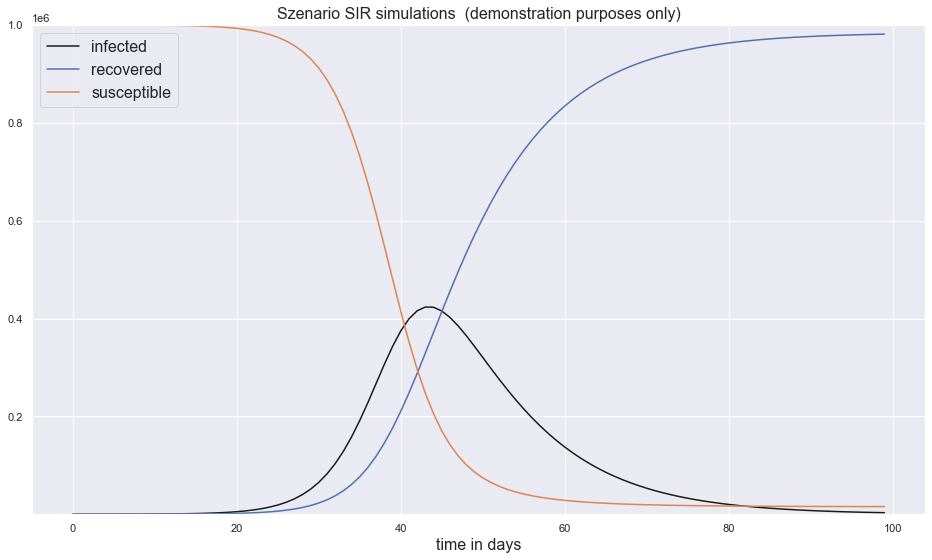

In [105]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

## Fitting the parameters of SIR model

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

ydata = np.array(df_analyse.Germany[50:100])
t=np.arange(len(ydata))

In [21]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta = 0.4
gamma = 0.1


In [22]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [23]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [24]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([2.36900000e+03, 3.19744539e+03, 4.31537791e+03, 5.82377162e+03,
       7.85867081e+03, 1.06032474e+04, 1.43039032e+04, 1.92916904e+04,
       2.60106555e+04, 3.50550719e+04, 4.72178485e+04, 6.35525702e+04,
       8.54513736e+04, 1.14739741e+05, 1.53786521e+05, 2.05621824e+05,
       2.74045129e+05, 3.63689024e+05, 4.79979061e+05, 6.28899346e+05,
       8.16446405e+05, 1.04765500e+06, 1.32514963e+06, 1.64735768e+06,
       2.00681426e+06, 2.38928064e+06, 2.77444259e+06, 3.13851842e+06,
       3.45825564e+06, 3.71502321e+06, 3.89759564e+06, 4.00288582e+06,
       4.03482262e+06, 4.00218408e+06, 3.91626333e+06, 3.78894731e+06,
       3.63142365e+06, 3.45347745e+06, 3.26322810e+06, 3.06714387e+06,
       2.87020419e+06, 2.67612197e+06, 2.48757403e+06, 2.30641320e+06,
       2.13385095e+06, 1.97060839e+06, 1.81703784e+06, 1.67321878e+06,
       1.53903271e+06, 1.41422077e+06])

In [25]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

standard deviation errors :  [0.01573943 0.01427613]  start infect: 2369
Optimal parameters: beta = 0.8109921560795365  and gamma =  0.6690385556072175


In [26]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

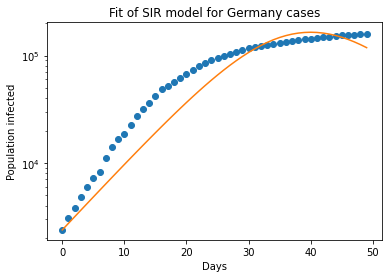

Optimal parameters: beta = 0.8109921560795365  and gamma =  0.6690385556072175
Basic Reproduction Number R0  1.2121755155702234
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infect


In [27]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infect")

## Fitting parameter of SIR Model

In [102]:
ydata = np.array(df_analyse.Spain[100:250])
t = np.arange(len(ydata))

new_Frame = df_analyse.drop('date',axis=1)
data_top = new_Frame.columns
new_Frame['Germany'][100:150]
    

100    160758
101    161703
102    162496
103    163175
104    163860
105    164807
106    166091
107    167300
108    168551
109    169218
110    169575
111    170508
112    171306
113    172239
114    173152
115    173772
116    174355
117    174697
118    175210
119    176007
120    176752
121    177212
122    177850
123    178281
124    178570
125    179002
126    179364
127    179717
128    180458
129    181196
130    181482
131    181815
132    182028
133    182370
134    182764
135    183271
136    183678
137    183979
138    184193
139    184543
140    184861
141    185416
142    185674
143    186022
144    186269
145    186461
146    186839
147    187184
148    187764
149    188534
Name: Germany, dtype: int64

In [93]:
N0 = 10000000

I0 = ydata[0]
S0 = N0-I0
R0 = 0

print('Start infected people:', I0)
print('Cumulative sum of infected after period:', ydata[-1])
print('Number of days:', len(ydata))
print('N0', N0)

Start infected people: 215216
Cumulative sum of infected after period: 716481
Number of days: 150
N0 10000000


In [94]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve ## get the final fitted curve
fitted=fit_odeint(t, *popt)

standard deviation errors :  [0.02233693 0.02035311]  start infect: 215216
Optimal parameters: beta = 0.014055102313449986  and gamma =  0.0071791313484889496


In [103]:
new_Frame = df_analyse.drop('date',axis=1)
data_top = new_Frame.columns
data_top

Index(['Italy', 'US', 'Spain', 'Germany', 'Australia'], dtype='object')

## Vis 2

In [65]:
df_analyse = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse = df_analyse.sort_values('date',ascending=True)
new_Frame = df_analyse.drop('date',axis=1)
data_top = new_Frame.columns


beta = 0.4
gamma = 0.1
R0 = 0
N0 = 10000000

i=100
n=900

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt


ydata1=np.array(new_Frame['Germany'][i:n])
t = np.arange(len(ydata1))
N0 = 80000000
I0 = ydata1[0]
S0 = N0-I0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata1) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
fitted1=fit_odeint(t, *popt)

ydata2=np.array(new_Frame['Italy'][i:n])
I0 = ydata2[0]
N0 = 330000000
S0 = N0-I0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata2) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
fitted2=fit_odeint(t, *popt)

ydata3=np.array(new_Frame['US'][i:n])
I0 = ydata3[0]
S0 = N0-I0
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata3) ## Train the model / Fit the model
perr = np.sqrt(np.diag(pcov))
fitted3=fit_odeint(t, *popt)


fittedData = pd.DataFrame({'Germany': fitted1,'Italy': fitted2, 'US': fitted3})

ydata = pd.DataFrame({'Germany': ydata1,'Italy': ydata2, 'US': ydata3})


In [ ]:
import pandas as pd
import numpy as np

from scipy import optimize
from scipy import integrate

import dash
dash.__version__
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "browser"

import os
print(os.getcwd())


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Applied Data Science on COVID-19 data
    This dashboard shows the dynamic SIR-Model of three pre-selected countries
    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),


    dcc.Dropdown(
        id='drop_down_country',
        #options=[ {'label': each,'value':each} for each in data_top.unique()],
        options=[ 
            {'label': 'Germany','value': 'Germany'},
            {'label': 'US','value': 'US'},
            {'label': 'Italy','value': 'Italy'}],
        value=['Germany'], # which are pre-selected
        multi=True
    ),

    dcc.Graph(figure=fig, id='main_window_slope1')
])



@app.callback(
    Output(component_id='main_window_slope1', component_property='figure'),
    [Input(component_id='drop_down_country', component_property='value')]
)
def update_figure(country_list):
    
    my_yaxis={'type':"log",
               'title':'Number of Infections'
              }

    traces = []
    for each in country_list:

        #df_plot=df_input_large[df_input_large['country']==each]
        df_plot=ydata
        
        
        
        traces.append(dict(x=t,
                                    y=fittedData[each],
                                    mode='markers+lines',
                                    marker = dict(
                                      size = 3
                                    ),
                                    opacity=0.9,
                                    name=each +"fitted"
                            )
                    )
        traces.append(dict(x=t,
                                    y=ydata[each],
                                    mode='markers',
                                    marker = dict(
                                      size = 5
                                    ),
                                    opacity=0.9,
                                    name=each
                            )
                    )
        

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

C:\Users\demb011\Enterprise_Data_Science\Enterprise_Data_Science\notebooks
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on htt

In [ ]:
%load ../src/visualization/visSIR.py

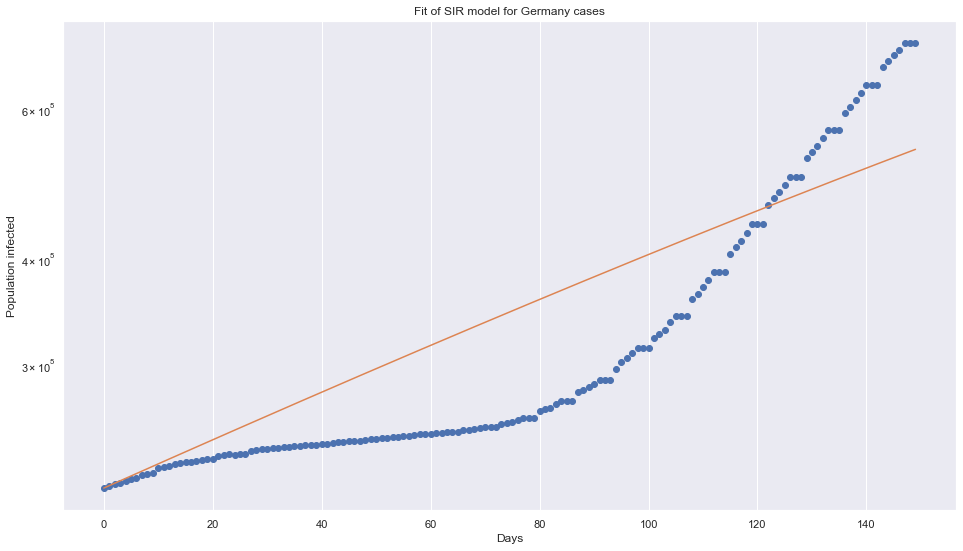

Optimal parameters: beta = 0.014055102313449986  and gamma =  0.0071791313484889496
Basic Reproduction Number R0  1.9577719965254958
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infect


In [178]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infect")

In [58]:
df_analyse = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df_analyse = df_analyse.sort_values('date',ascending=True)
new_Frame = df_analyse.drop('date',axis=1)
data_top = new_Frame.columns
df_analyse

,date,Italy,US,Spain,Germany,Australia
0,2020-01-22,0,1,0,0,0
1,2020-01-23,0,1,0,0,0
2,2020-01-24,0,2,0,0,0
3,2020-01-25,0,2,0,0,0
4,2020-01-26,0,5,0,0,4
...,...,...,...,...,...,...
909,2022-07-19,20299013,89830497,13132159,29994679,8912149
910,2022-07-20,20385814,90046261,13132159,30131303,8967138
911,2022-07-21,20467349,90200438,13132159,30239122,9018965
912,2022-07-22,20539016,90367064,13204863,30331131,9065275


## Dynamic beta in SIR

In [114]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [115]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)
    #new_Frame = pd.DataFrame({'susceptible':SIR[0],'infected':SIR[1],'recovered':SIR[2]},index=[0])
    
    #propagation_rates=pd.concat([propagation_rates,new_Frame])

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\42122228.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\42122228.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\42122228.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\42122228.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\demb011\AppData\Local\Temp\ipykernel_22768\42122228.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

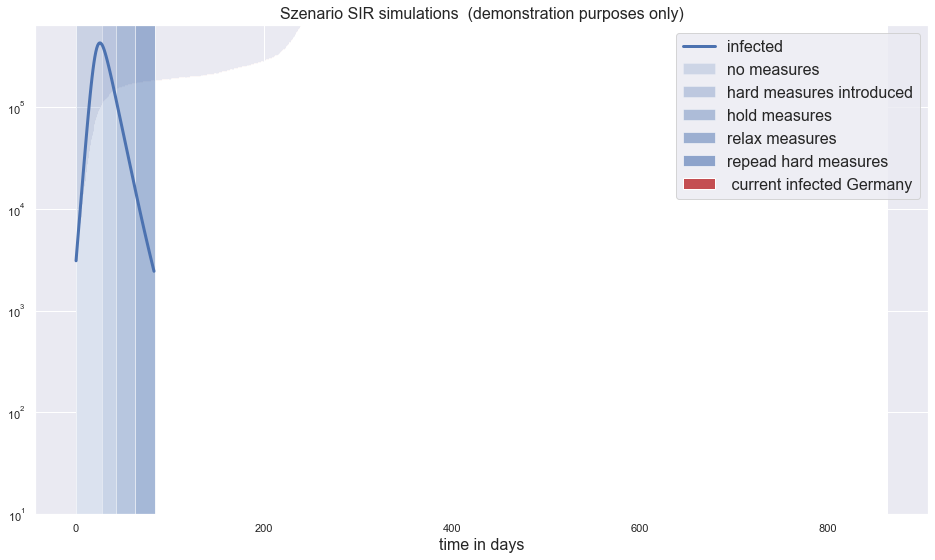

In [116]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()

ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});